In [1]:
import pandas as pd
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torchvision.transforms.functional import pil_to_tensor
from PIL import Image
from typing import Tuple

In [2]:
class AffectNetDataset(Dataset):
    def __init__(
        self,
        dataset_path: str,
        labels_filename: str,
        img_size: int,
        patch_size: int,
        nb_mask: int = 4,
        aspect_ratio_range_mask: Tuple[int, int] = (0.75, 1.5),
        scale_range_mask: Tuple[int, int] = (0.15, 0.2),
        aspect_ratio_range_context: Tuple[int, int] = (
            1.0,
            1.0,
        ),  # unit aspect ratio for context
        scale_range_context: Tuple[int, int] = (0.85, 1.0),
    ):
        self.df = pd.read_csv(os.path.join(dataset_path, labels_filename))
        self.dataset_path = dataset_path

        self.img_size = img_size
        self.patch_size = patch_size
        self.sqrt_count_patch = img_size // patch_size
        self.nb_mask = nb_mask

        self.aspect_ratio_range_mask = aspect_ratio_range_mask
        self.scale_range_mask = scale_range_mask

        self.aspect_ratio_range_context = aspect_ratio_range_context
        self.scale_range_context = scale_range_context

    def __len__(self):
        """
        Returns the length of the dataset, which is the length of `df`.
        """
        return len(self.df)

    def get_random_width_and_height(self, n: int):
        """
        Returns a random height and weight based on a random aspect ratio and a random scale.\\
        Length of height and width is `n+1`, the first `n` elements being masks height and width, and the last one being the context height and weight.

        Parameters:
        - `n`: the number of height and width to be generated. 
        """
        aspect_ratio = torch.FloatTensor(n).uniform_(*self.aspect_ratio_range_mask)
        scale = torch.FloatTensor(n).uniform_(*self.scale_range_mask)

        aspect_ratio = torch.cat((
            aspect_ratio,
            torch.FloatTensor(1).uniform_(*self.aspect_ratio_range_context))
        )
        scale = torch.cat(
            (scale, torch.FloatTensor(1).uniform_(*self.scale_range_context))
        )

        # calculate area, width and height of each mask and context
        area = scale * (self.sqrt_count_patch**2)
        height = torch.sqrt(area / aspect_ratio).round().int()
        width = torch.sqrt(area * aspect_ratio).round().int()

        return height, width

    def __getitem__(self, idx):
        """
        Returns a tuple of 3 elements:
        -
        -
        -
        """
        img_path = os.path.join(self.dataset_path, self.df.iloc[idx]["pth"])
        img = pil_to_tensor(Image.open(img_path)).permute(1, 2, 0)  # 96 x 96 x 3

        # random height and width for masks
        heights, widths = self.get_random_width_and_height(self.nb_mask)
        xs = np.random.randint(low=self.sqrt_count_patch - widths[:-1].int() + 1)
        ys = np.random.randint(low=self.sqrt_count_patch - heights[:-1].int() + 1)

        # calculate patch indexes of mask
        masks = []
        masks_indexes = set()
        z = zip(xs, ys, heights[:-1], widths[:-1])
        for x, y, height, width in z:
            tmp_mask = torch.cat(
                [
                    torch.arange(x, x + width) + (y + i) * self.sqrt_count_patch
                    for i in range(height)
                ]
            )

            masks_indexes.update(tmp_mask.tolist())
            masks.append(tmp_mask)

        context_indexes = set(
            torch.cat(
                [
                    torch.arange(xs[-1], xs[-1] + widths[-1])
                    + (ys[-1] + i) * self.sqrt_count_patch
                    for i in range(heights[-1])
                ]
            ).tolist()
        )

        patches = img.view(self.sqrt_count_patch, self.patch_size, self.sqrt_count_patch, self.patch_size, 3) # 12, 8, 12, 8, 3
        patches = patches.permute(0, 2, 1, 3, 4) # 12, 12, 8, 8, 3
        patches = patches.reshape(-1, self.patch_size, self.patch_size, 3)

        return (
            patches,
            context_indexes - masks_indexes,
            masks,
        )


In [3]:
dataset = AffectNetDataset(
    dataset_path=os.path.join("dataset", "archive"),
    labels_filename="labels.csv",
    img_size=96,
    patch_size=12,
)

In [8]:
img, context_indexes, masks = dataset[0]

In [9]:
print(masks)

[tensor([35, 36, 37, 38, 43, 44, 45, 46, 51, 52, 53, 54]), tensor([24, 25, 26, 27, 32, 33, 34, 35, 40, 41, 42, 43]), tensor([44, 45, 46, 52, 53, 54, 60, 61, 62]), tensor([10, 11, 12, 13, 18, 19, 20, 21, 26, 27, 28, 29])]


[]

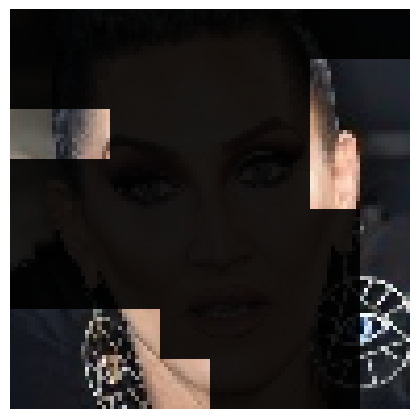

In [10]:
l = dataset.sqrt_count_patch

f, axarr = plt.subplots(l, l, gridspec_kw={'wspace': 0, 'hspace': 0},  figsize=(4, 4))
for i in range(l):
  for j in range(l):
    if i * l + j in context_indexes:
      axarr[i, j].imshow(img[i * l + j])
    else:
      axarr[i, j].imshow(img[i * l + j] // 10)
    axarr[i, j].axis("off")
    axarr[i, j].grid(False)

plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0, hspace=0)
plt.plot()